The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Differentiation and Integration

This chapter picks up where the previous chapter left off, looking at the relationship between windows in the time domain and filters in the frequency domain.

In particular, we'll look at the effect of a finite difference window, which approximates differentiation, and the cumulative sum operation, which approximates integration.

The code for this chapter is in `chap09.ipynb`, which is in the repository for this book (see Section [\[code\]](#code){reference-type="ref" reference="code"}).
You can also view it at <http://tinyurl.com/thinkdsp09>.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP/blob/v2/nb/chap01.ipynb).

In [1]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP/raw/v2/nb/thinkdsp.py")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_power, decorate_corr

PI2 = 2 * np.pi

## Finite differences

In Section [\[smoothing\]](#smoothing){reference-type="ref" reference="smoothing"}, we applied a smoothing window to the stock price of Facebook and found that a smoothing window in the time domain corresponds to a low-pass filter in the frequency domain.

In this section, we'll look at daily price changes and see that computing the difference between successive elements, in the time domain, corresponds to a high-pass filter.

Here's the code to read the data, store it as a wave, and compute its spectrum.

In [3]:
import pandas as pd

download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv')

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])

In [4]:
from thinkdsp import Wave

ys = df['Close']

# for these examples, we need the wave to have 
# an even number of samples
if len(ys) % 2:
    ys = ys[:-1]

close = Wave(ys, framerate=1)
close_spectrum = close.make_spectrum()

This example uses Pandas to read the CSV file; the result is a DataFrame, `df`, with columns for the opening price, closing price, and high and low prices.
I select the closing prices and save them in a Wave object.
The framerate is 1 sample per day.

The following figure shows this time series and its spectrum.

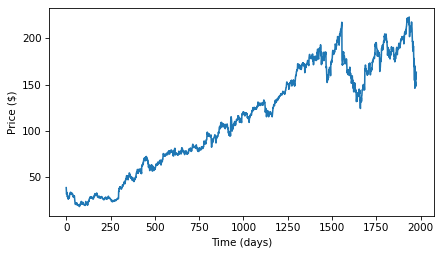

In [5]:
close.plot()
decorate(xlabel='Time (days)', ylabel='Price ($)')

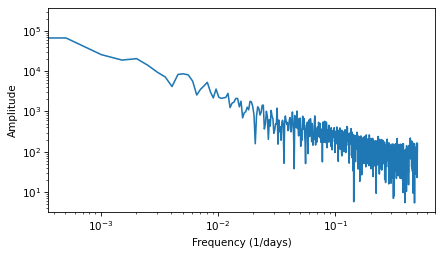

In [6]:
close_spectrum.plot()
decorate(xlabel='Frequency (1/days)', ylabel='Amplitude',
         xscale='log', yscale='log')

Visually, the time series resembles Brownian noise (see Section [\[brownian\]](#brownian){reference-type="ref" reference="brownian"}).
And the spectrum looks like a straight line, albeit a noisy one.
The estimated slope is -1.9, which is consistent with Brownian noise.

In [7]:
close_spectrum.estimate_slope()

LinregressResult(slope=np.float64(-1.7895322348034628), intercept=np.float64(6.7661082321703025), rvalue=np.float64(-0.8290498996343667), pvalue=np.float64(3.697461877665865e-251), stderr=np.float64(0.038438625905822366), intercept_stderr=np.float64(0.07514429918555761))

Now let's compute the daily price change using `np.diff`:

In [8]:
diff = np.diff(close.ys)
change = Wave(diff, framerate=1)
change_spectrum = change.make_spectrum()

The following figure shows the resulting wave and its spectrum.
The daily changes resemble white noise, and the estimated slope of the spectrum, -0.06, is near zero, which is what we expect for white noise.

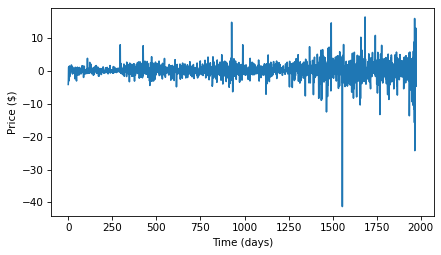

In [9]:
change.plot()
decorate(xlabel='Time (days)', ylabel='Price ($)')

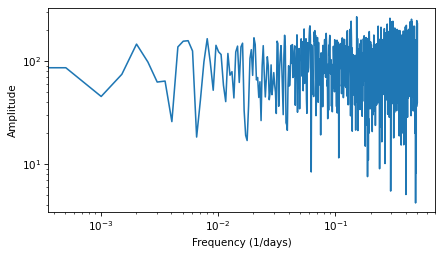

In [10]:
change_spectrum.plot()
decorate(xlabel='Frequency (1/days)', ylabel='Amplitude',
         xscale='log', yscale='log')

In [11]:
change_spectrum.estimate_slope()

LinregressResult(slope=np.float64(0.09137404305435809), intercept=np.float64(9.050903879908967), rvalue=np.float64(0.07246236086326042), pvalue=np.float64(0.02280854582800629), stderr=np.float64(0.04007274082912973), intercept_stderr=np.float64(0.07835602090198657))

## The frequency domain

Computing the difference between successive elements is the same as convolution with the window `[1, -1]`.
If the order of those elements seems backward, remember that convolution reverses the window before applying it to the signal.

We can see the effect of this operation in the frequency domain by computing the DFT of the window.

In [12]:
from thinkdsp import zero_pad

diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(close))
diff_wave = Wave(padded, framerate=close.framerate)
diff_filter = diff_wave.make_spectrum()

The following figure shows the result.

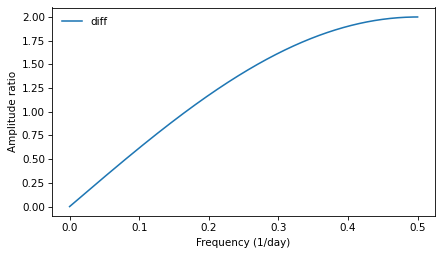

In [13]:
diff_filter.plot(label='diff')
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

The finite difference window corresponds to a high pass filter: its amplitude increases with frequency, linearly for low frequencies, and then sublinearly after that.
In the next section, we'll see why.

## Differentiation

The window we used in the previous section is a numerical approximation of the first derivative, so the filter approximates the effect of differentiation.

Differentiation in the time domain corresponds to a simple filter in the frequency domain; we can figure out what it is with a little math.

Suppose we have a complex sinusoid with frequency $f$:

$$E_f(t) = e^{2 \pi i f t}$$

The first derivative of $E_f$ is:

$$\frac{d}{dt} E_f(t) = 2 \pi i f e^{2 \pi i f t}$$

which we can rewrite as:

$$\frac{d}{dt} E_f(t) = 2 \pi i f E_f(t)$$

In other words, taking the derivative of $E_f$ is the same as multiplying by $2 \pi i f$, which is a complex number with magnitude $2 \pi f$ and angle $\pi/2$.

We can compute the filter that corresponds to differentiation, like this:

In [14]:
deriv_filter = close.make_spectrum()
deriv_filter.hs = PI2 * 1j * deriv_filter.fs

I started with the spectrum of `close`, which has the right size and framerate, then replaced the `hs` with $2 \pi i f$. The following figure shows this filter; it is a straight line.

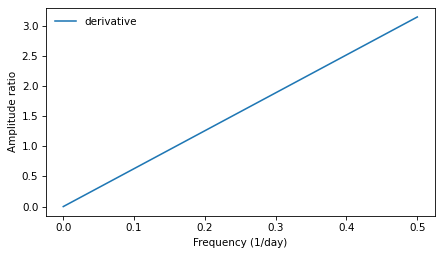

In [15]:
deriv_filter.plot(label='derivative')
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio')

As we saw in Section [\[synthmat\]](#synthmat){reference-type="ref" reference="synthmat"}, multiplying a complex sinusoid by a complex number has two effects: it multiplies the amplitude, in this case by $2 \pi f$, and shifts the phase offset, in this case by $\pi/2$.

If you are familiar with the language of operators and eigenfunctions, each $E_f$ is an eigenfunction of the differentiation operator, with the corresponding eigenvalue $2 \pi i f$. See <http://en.wikipedia.org/wiki/Eigenfunction>.

If you are not familiar with that language, here's what it means:

-   An operator is a function that takes a function and returns another function.
For example, differentiation is an operator.

-   A function, $g$, is an eigenfunction of an operator, $\mathcal{A}$, if applying $\mathcal{A}$ to $g$ has the effect of multiplying the function by a scalar.
That is, $\mathcal{A}g = \lambda g$.

-   In that case, the scalar $\lambda$ is the eigenvalue that corresponds to the eigenfunction $g$.

-   A given operator might have many eigenfunctions, each with a corresponding eigenvalue.

Because complex sinusoids are eigenfunctions of the differentiation operator, they are easy to differentiate.
All we have to do is multiply by a complex scalar.

For signals with more than one component, the process is only slightly harder:

1.  Express the signal as the sum of complex sinusoids.

2.  Compute the derivative of each component by multiplication.

3.  Add up the differentiated components.

If that process sounds familiar, that's because it is identical to the algorithm for convolution in Section [\[effconv\]](#effconv){reference-type="ref" reference="effconv"}: compute the DFT, multiply by a filter, and compute the inverse DFT.

`Spectrum` provides a method that applies the differentiation filter:

In [16]:
# class Spectrum:

def differentiate(self):
    """Apply the differentiation filter."""
    new = self.copy()
    new.hs *= PI2 * 1j * new.fs
    return new

We can use it to compute the derivative of the Facebook time series:

In [17]:
deriv_spectrum = close_spectrum.differentiate()
deriv = deriv_spectrum.make_wave()

The following figure compares the daily price changes computed by `np.diff` with the derivative we just computed.
I selected the first 50 values in the time series so we can see the differences more clearly.

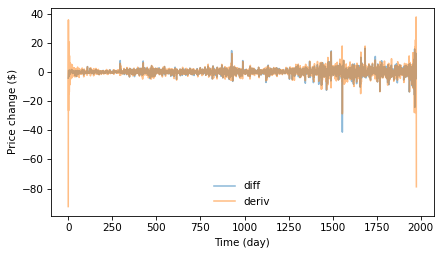

In [18]:
change.plot(alpha=0.5, label='diff')
deriv.plot(alpha=0.5, label='deriv')
decorate(xlabel='Time (day)', ylabel='Price change ($)')

The derivative is noisier, because it amplifies the high frequency components more, as shown in the earlier figure.
Also, the first few elements of the derivative are very noisy.
The problem there is that the DFT-based derivative is based on the assumption that the signal is periodic.
In effect, it connects the last element in the time series back to the first element, which creates artifacts at the boundaries.

To summarize, we have shown:

-   Computing the difference between successive values in a signal can be expressed as convolution with a simple window.
The result is an approximation of the first derivative.

-   Differentiation in the time domain corresponds to a simple filter in the frequency domain.
For periodic signals, the result is the first derivative, exactly.
For some non-periodic signals, it can approximate the derivative.

Using the DFT to compute derivatives is the basis of **spectral methods** for solving differential equations (see <http://en.wikipedia.org/wiki/Spectral_method>).

In particular, it is useful for the analysis of linear, time-invariant systems, which is coming up in Chapter [\[systems\]](#systems){reference-type="ref" reference="systems"}.

## Integration

In the previous section, we showed that differentiation in the time domain corresponds to a simple filter in the frequency domain: it multiplies each component by $2 \pi i f$. Since integration is the inverse of differentiation, it also corresponds to a simple filter: it divides each component by $2 \pi i f$.

We can compute this filter like this:

In [19]:
integ_filter = close.make_spectrum()
integ_filter.hs[1:] = 1 / (PI2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

The following figure shows this filter on a log-$y$ scale, which makes it easier to see.

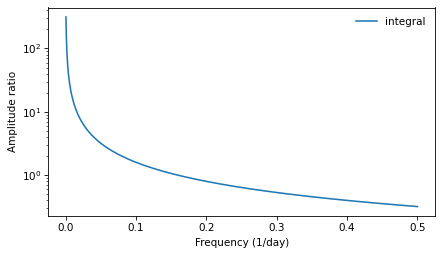

In [20]:
integ_filter.plot(label='integral')
decorate(xlabel='Frequency (1/day)', ylabel='Amplitude ratio', 
         yscale='log')

`Spectrum` provides a method that applies the integration filter:

In [21]:
# class Spectrum:

def integrate(self):
    """Apply the integration filter."""
    new = self.copy()
    zero = new.fs == 0
    new.hs[~zero] /= PI2 * 1j * new.fs[~zero]
    new.hs[zero] = np.inf
    return new

We can confirm that the integration filter is correct by applying it to the spectrum of the derivative we just computed:

In [22]:
integ_spectrum = deriv_spectrum.integrate()

But notice that at $f=0$, we are dividing by 0. The result in NumPy is NaN, which is a special floating-point value that represents "not a number".
We can partially deal with this problem by setting this value to 0 before converting the spectrum back to a wave:

In [23]:
integ_spectrum.hs[0] = 0
integ_wave = integ_spectrum.make_wave()

The following figure shows this integrated derivative along with the original time series.

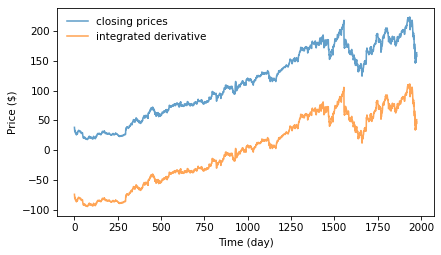

In [24]:
close.plot(label='closing prices', alpha=0.7)
integ_wave.plot(label='integrated derivative', alpha=0.7)
decorate(xlabel='Time (day)', ylabel='Price ($)')

They are almost identical, but the integrated derivative has been shifted down.
The problem is that when we clobbered the $f=0$ component, we set the bias of the signal to 0. But that should not be surprising; in general, differentiation loses information about the bias, and integration can't recover it. In some sense, the NaN at $f=0$ is telling us that this element is unknown.

If we provide this "constant of integration", the results are identical, which confirms that this integration filter is the correct inverse of the differentiation filter.

## Cumulative sum

In the same way that the diff operator approximates differentiation, the cumulative sum approximates integration.
I'll demonstrate with a Sawtooth signal.

In [25]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=50)
in_wave = signal.make_wave(duration=0.1, framerate=44100)
in_wave.unbias()

The following figure shows this wave and its spectrum.

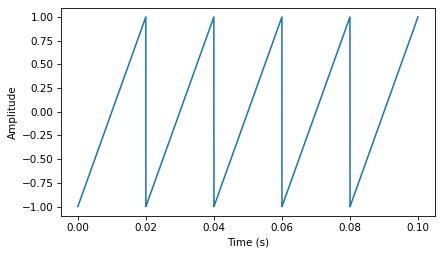

In [26]:
in_wave.plot()
decorate_time()

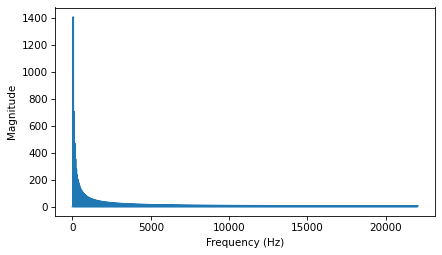

In [27]:
in_wave.make_spectrum().plot()
decorate_freq()

`Wave` provides a method that computes the cumulative sum of a wave array and returns a new Wave object:

In [28]:
# class Wave:

def cumsum(self):
    ys = np.cumsum(self.ys)
    ts = self.ts.copy()
    return Wave(ys, ts, self.framerate)

We can use it to compute the cumulative sum of `in_wave`:

In [29]:
out_wave = in_wave.cumsum()
out_wave.unbias()

The following figure shows the resulting wave and its spectrum.
If you did the exercises in Chapter [\[harmonics\]](#harmonics){reference-type="ref" reference="harmonics"}, this waveform should look familiar: it's a parabolic signal.

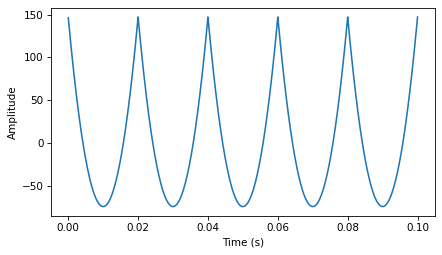

In [30]:
out_wave.plot()
decorate_time()

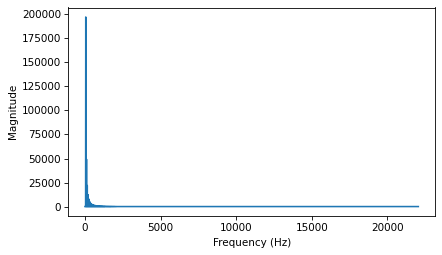

In [31]:
spectrum = out_wave.make_spectrum()
spectrum.plot()
decorate_freq()

Comparing the spectrum of the parabolic signal to the spectrum of the sawtooth, the amplitudes of the components drop off more quickly.
In Chapter xxx, we saw that the components of the sawtooth drop off in proportion to $1/f$.
Since the cumulative sum approximates integration, and integration filters components in proportion to $1/f$, the components of the parabolic wave drop off in proportion to $1/f^2$.

We can see that graphically by computing the filter that corresponds to the cumulative sum:

In [32]:
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()

In [33]:
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

Because `cumsum` is the inverse operation of `diff`, we start with a copy of `diff_filter`, which is the filter that corresponds to the `diff` operation, and then invert the `hs`.

The following figure shows the filters corresponding to cumulative sum and integration.
The cumulative sum is a good approximation of integration except at the highest frequencies, where it drops off a little faster.

To confirm that this is the correct filter for the cumulative sum, we can compare it to the ratio of the spectrum `out_wave` to the spectrum of `in_wave`:

In [34]:
in_spectrum = in_wave.make_spectrum()
out_spectrum = out_wave.make_spectrum()

ratio_spectrum = out_spectrum.ratio(in_spectrum, thresh=1)

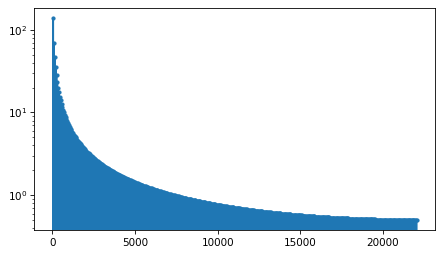

In [35]:
ratio_spectrum.plot(ls=None, marker='.')
decorate(yscale='log')

The following figure shows the ratios and the filter corresponding to the cumulative sum.

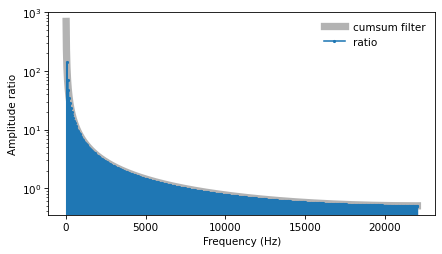

In [36]:
cumsum_filter.plot(label='cumsum filter', color='0.7', linewidth=7)
ratio_spectrum.plot(label='ratio', marker='.', markersize=4)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio', yscale='log')

They agree, which confirms that inverting the filter for `diff` yields the filter for ` cumsum`.

Finally, we can confirm that the Convolution Theorem applies by applying the `cumsum` filter in the frequency domain:

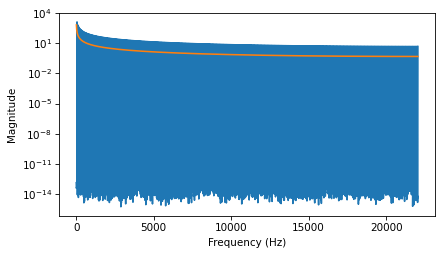

In [37]:
in_spectrum.plot()
cumsum_filter.plot()
decorate_freq()
decorate(yscale='log')

In [38]:
cumsum_filter.hs[0] = 0
out_wave2 = (in_spectrum * cumsum_filter).make_wave()

Within the limits of floating-point error, `out_wave2` is identical to `out_wave`, which we computed using `cumsum`, so the Convolution Theorem works! But note that this demonstration only works with periodic signals.

In [39]:
out_wave.max_diff(out_wave2)

np.float64(8.135714324453147e-13)

## Integrating noise

In Section [\[brownian\]](#brownian){reference-type="ref" reference="brownian"}, we generated Brownian noise by computing the cumulative sum of white noise.
Now that we understand the effect of `cumsum` in the frequency domain, we have some insight into the spectrum of Brownian noise.

White noise has equal power at all frequencies, on average.
When we compute the cumulative sum, the amplitude of each component is divided by $f$.
Since power is the square of magnitude, the power of each component is divided by $f^2$.
So on average, the power at frequency $f$ is proportional to $1 / f^2$:

$$P_f = K / f^2$$

where $K$ is a constant that's not important.
Taking the log of both sides yields:

$$\log P_f = \log K - 2 \log f$$

And that's why, when we plot the spectrum of Brownian noise on a log-log scale, we expect to see a straight line with slope -2, at least approximately.

In Section [\[diffs\]](#diffs){reference-type="ref" reference="diffs"} we plotted the spectrum of closing prices for Facebook, and estimated that the slope is -1.9, which is consistent with Brownian noise.
Many stock prices have similar spectrums.

When we use the `diff` operator to compute daily changes, we multiplied the *amplitude* of each component by a filter proportional to $f$, which means we multiplied the *power* of each component by $f^2$.
On a log-log scale, this operation adds 2 to the slope of the power spectrum, which is why the estimated slope of the result is near 0.1 (but a little lower, because `diff` only approximates differentiation).

## Exercises

## Exercise 1

The goal of this exercise is to explore the effect of `diff` and `differentiate` on a signal.
Create a triangle wave and plot it.  Apply the `diff` operator and plot the result.
Compute the spectrum of the triangle wave, apply `differentiate`, and plot the result.
Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `diff` and `differentiate` for this wave?

*Solution:* Here's the triangle wave.

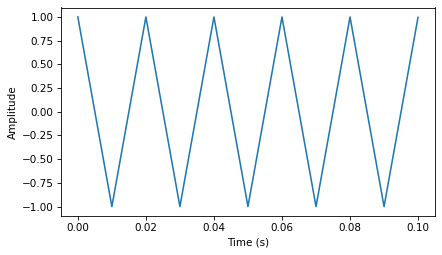

In [40]:
from thinkdsp import TriangleSignal

in_wave = TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate_time()

The diff of a triangle wave is a square wave, which explains why the harmonics in a square wave drop off like $1/f$, compared to the triangle wave, which drops off like $1/f^2$.

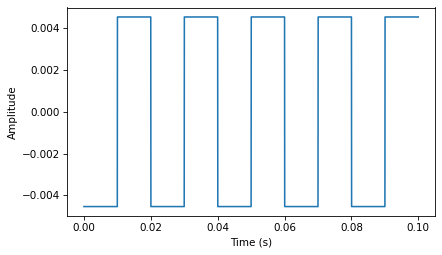

In [41]:
out_wave = in_wave.diff()
out_wave.plot()
decorate_time()

When we take the spectral derivative, we get "ringing" around the discontinuities: https://en.wikipedia.org/wiki/Ringing_(signal)

Mathematically speaking, the problem is that the derivative of the triangle wave is undefined at the points of the triangle.

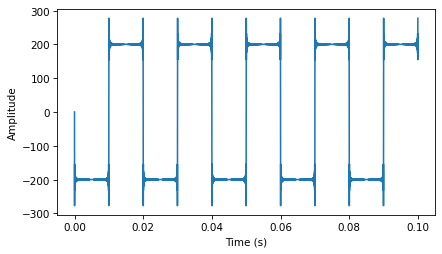

In [42]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()
out_wave2.plot()
decorate_time()

## Exercise 2

The goal of this exercise is to explore the effect of `cumsum` and `integrate` on a signal.
Create a square wave and plot it.  Apply the `cumsum` operator and plot the result.
Compute the spectrum of the square wave, apply `integrate`, and plot the result.
Convert the spectrum back to a wave and plot it.  Are there differences between the effect of `cumsum` and `integrate` for this wave?

*Solution:* Here's the square wave.

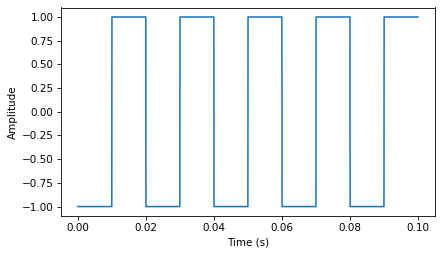

In [43]:
from thinkdsp import SquareSignal

in_wave = SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate_time()

The cumulative sum of a square wave is a triangle wave.
After the previous exercise, that should come as no surprise.

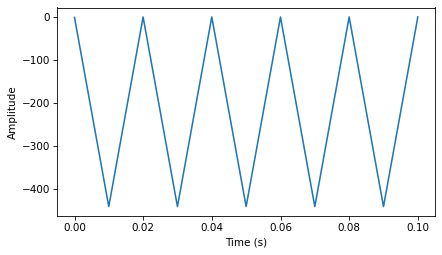

In [44]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate_time()

The spectral integral is also a triangle wave, although the amplitude is very different.

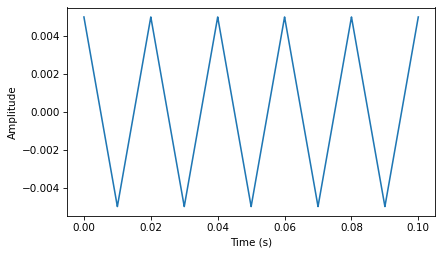

In [45]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate_time()

If we unbias and normalize the two waves, they are visually similar.

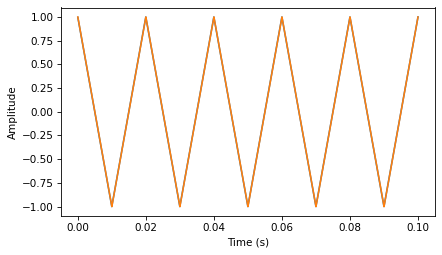

In [46]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()
decorate_time()

And they are numerically similar, but with only about 3 digits of precision.

In [47]:
out_wave.max_diff(out_wave2)

np.float64(0.0045351473922902175)

## Exercise 3

The goal of this exercise is the explore the effect of integrating twice.
Create a sawtooth wave, compute its spectrum, then apply `integrate` twice.
Plot the resulting wave and its spectrum.
What is the mathematical form of the wave?  Why does it resemble a sinusoid? 

Here's the sawtooth.

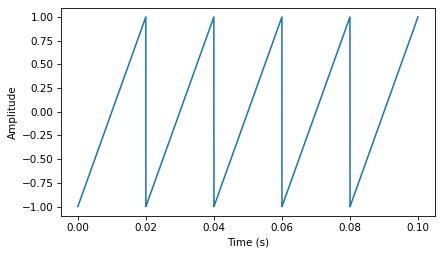

In [48]:
from thinkdsp import SawtoothSignal

in_wave = SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate_time()

The first cumulative sum of a sawtooth is a parabola:

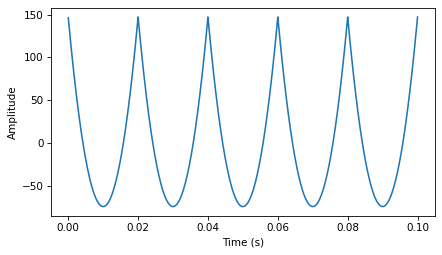

In [49]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate_time()

The second cumulative sum is a cubic curve:

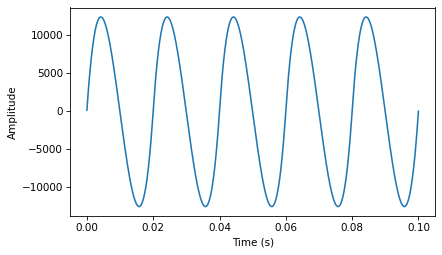

In [50]:
out_wave = out_wave.cumsum()
out_wave.plot()
decorate_time()

Integrating twice also yields a cubic curve.

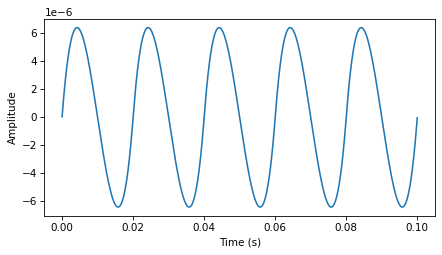

In [51]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate_time()

At each step, the result looks more and more like a sinusoid.
The reason is that integration acts like a low pass filter.
At this point we have filtered out almost everything except the fundamental, as shown in the spectrum below:

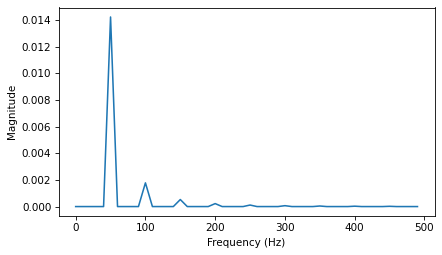

In [52]:
out_wave2.make_spectrum().plot(high=500)
decorate_freq()

## Exercise 4 

The goal of this exercise is to explore the effect of the 2nd difference and 2nd derivative.
Create a `CubicSignal`, which is defined in `thinkdsp`.
Compute the second difference by applying `diff` twice.
What does the result look like.
Compute the second derivative by applying `differentiate` twice.
Does the result look the same?

Plot the filters that corresponds to the 2nd difference and the 2nd derivative and compare them.
Hint: In order to get the filters on the same scale, use a wave with framerate 1.

*Solution:* Here's the cubic signal

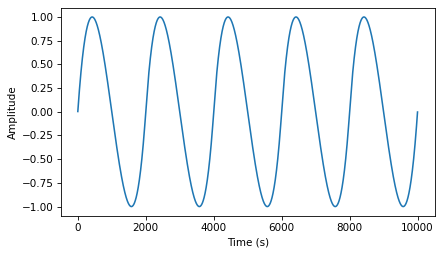

In [53]:
from thinkdsp import CubicSignal

in_wave = CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()
decorate_time()

The first difference is a parabola and the second difference is a sawtooth wave (no surprises so far):

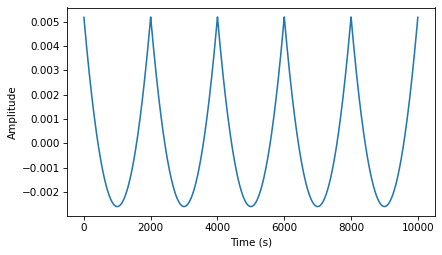

In [54]:
out_wave = in_wave.diff()
out_wave.plot()
decorate_time()

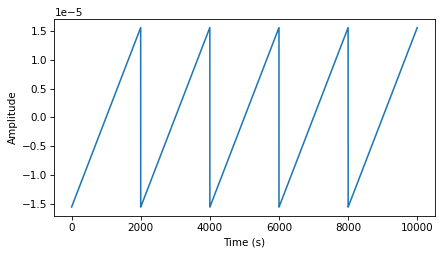

In [55]:
out_wave = out_wave.diff()
out_wave.plot()
decorate_time()

When we differentiate twice, we get a sawtooth with some ringing.
Again, the problem is that the deriviative of the parabolic signal is undefined at the points.

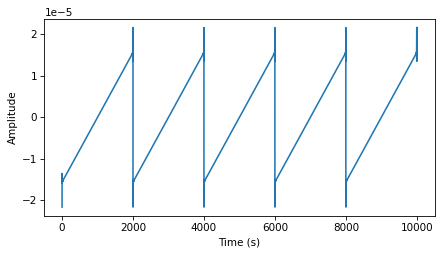

In [56]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate_time()

The window of the second difference is -1, 2, -1.  By computing the DFT of the window, we can find the corresponding filter.

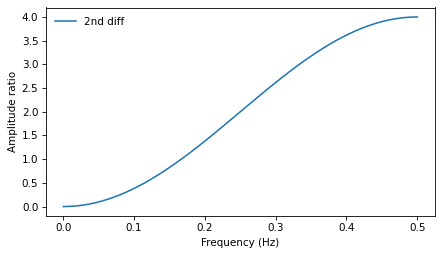

In [57]:
diff_window = np.array([-1.0, 2.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label='2nd diff')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

And for the second derivative, we can find the corresponding filter by computing the filter of the first derivative and squaring it.

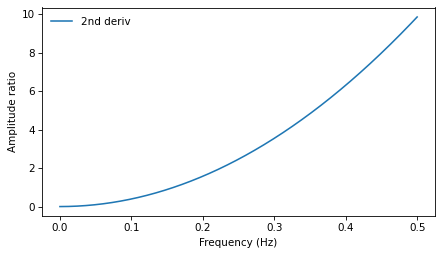

In [58]:
deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (PI2 * 1j * deriv_filter.fs)**2
deriv_filter.plot(label='2nd deriv')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Here's what the two filters look like on the same scale:

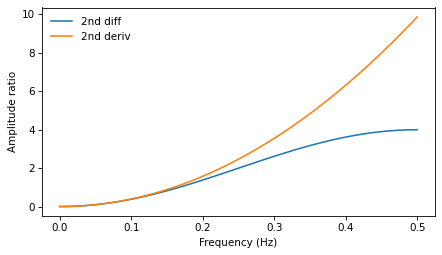

In [59]:
diff_filter.plot(label='2nd diff')
deriv_filter.plot(label='2nd deriv')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Both are high pass filters that amplify the highest frequency components.
The 2nd derivative is parabolic, so it amplifies the highest frequencies the most.
The 2nd difference is a good approximation of the 2nd derivative only at the lowest frequencies, then it deviates substantially.

[Think DSP: Digital Signal Processing in Python, 2rd Edition](https://allendowney.github.io/ThinkDSP/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)